In [1]:
from IPython.core.display import HTML, display
from collections import namedtuple as NT

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as pl
from matplotlib import rcParams

from keras import models
from keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from keras import regularizers
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import plot_model
from keras import backend as K
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [2]:
display(HTML("<style>.container {width:90% !important}</style>"))

In [3]:
% matplotlib inline
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['axes.titlesize'] = 18
rcParams['figure.titlesize'] = 20

In [4]:
band = 411
d_ = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF_SAT.pkl')

In [5]:
def build_cnn_model():
    l1_decay = 0.00001
    model = models.Sequential()
    model.add(Conv1D(128, kernel_size=(5,), strides=4, activation='relu', padding='same', input_shape=((6,1)),
                    kernel_regularizer=regularizers.l1(l1_decay)))
    model.add(Conv1D(64, kernel_size=5, strides=4, activation='relu', padding='same'))
    model.add(Conv1D(32, kernel_size=5, strides=4, activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(163, activation='relu', kernel_regularizer=regularizers.l1(l1_decay)))
    model.add(Dense(163, activation='relu', kernel_regularizer=regularizers.l1(l1_decay)))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [19]:
def Cross_Fold_Validation(X_, y_, model_, k=4, num_epochs=100, verbose=0):
    results = dict(fold_val_mae=[], fold_val_mse=[],
                   val_mae_histories=[], train_mae_histories=[])
    kfold = KFold(n_splits=k, )
    for train_idx, val_idx in kfold.split(X_):
        history = model_.fit(X_[train_idx], y_[train_idx], epochs=num_epochs,
                            validation_data=(X_[val_idx], y_[val_idx]),
                            batch_size=1,  verbose=verbose)
        val_mse, val_mae = model_.evaluate(X_[val_idx], y_[val_idx], verbose=0)
        results['fold_val_mae'].append(val_mae)
        results['fold_val_mse'].append(val_mse)
        results['val_mae_histories'].append(history.history['val_mean_absolute_error'])
        results['train_mae_histories'].append(history.history['mean_absolute_error'])
    return results


def plot_mae_history(train_mae_histories, val_mae_histories, smoothed=False):
    avg_val_mae_history = [np.mean([x[i] for x in val_mae_histories])
                           for i in range(num_epochs)]
    avg_train_mae_history = [np.mean([x[i] for x in train_mae_histories])
                           for i in range(num_epochs)]
    if smoothed:
        avg_val_mae_history = smooth(avg_val_mae_history)
        avg_train_mae_history = smooth(avg_train_mae_history)
    _, ax = pl.subplots(figsize=(12,5))
    ax.plot(range(1, len(avg_val_mae_history) + 1), avg_val_mae_history, label='val')
    ax.plot(range(1, len(avg_train_mae_history) + 1), avg_train_mae_history, label='train',
           color='r')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('MAE');
    return ax

    
def plot_fits(model_, x_test_, y_test_):
    y_pred = model_.predict(x_test_)
    _, ax = pl.subplots(figsize=(10, 10))
    r2_  = r2_score(y_test_, y_pred)
    mae = mean_absolute_error(y_test_, y_pred, )
    min_ = min(y_pred.min(), y_test_.min())
    max_ = max(y_pred.max(), y_test_.max())
    ax.plot([min_, max_],[min_, max_], ls='--', color='k', label='1:1')
    ax.scatter(y_pred, y_test_, label='$r^2$ = %.2f, mae = %.2f' %(r2_, mae))
    ax.set_xlabel('predicted')
    ax.set_ylabel=('observed')
    ax.legend()
    ax.set_title('MLP - Test Data')
    return ax

    
def plot_fits_2(model_, x_test_, y_test_):
    y_pred = model_.predict(x_test_)
    ix = np.argsort(y_test_)
    xi = np.arange(ix.size)
    _, ax = pl.subplots(figsize=(12, 8))
    ax.scatter(xi, y_test_[ix], color='steelblue', edgecolor='k', s=50, label='observed')
    ax.scatter(xi, y_pred[ix], color='m', edgecolor='k', s=50, label='predicted')
    ax.legend();
    return ax

    
def smooth(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [7]:
X_sat = d_.dropna().filter(regex='sat')
y = d_.dropna().loc[:, 'log10_aphy%d' % band]

In [8]:
assert X_sat.shape[0] == y.size

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_sat, y, test_size=0.1, random_state=42)

In [10]:
y_train_ = y_train.values.reshape((-1,1))

In [11]:
y_test_ = y_test.values

In [12]:
X_train_ = np.expand_dims(X_train.values, 2)
X_test_ = np.expand_dims(X_test.values, 2)

In [13]:
X_train_.shape, X_test_.shape

((145, 6, 1), (17, 6, 1))

In [14]:
model_cnn = build_cnn_model()

In [15]:
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2, 128)            768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 64)             41024     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 32)             10272     
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 163)               5379      
_________________________________________________________________
dense_2 (Dense)              (None, 163)               26732     
_________________________________________________________________
dropout_1 (Dropout)          (None, 163)               0         
__________

In [16]:
num_epochs=1000
results_model_cnn = Cross_Fold_Validation(X_train_, y_train_, model_=model_cnn, num_epochs=num_epochs)

In [17]:
results_model_cnn['fold_val_mae']

[0.11666740235444661,
 0.1029640171262953,
 0.11152115133073595,
 0.08618304133415222]

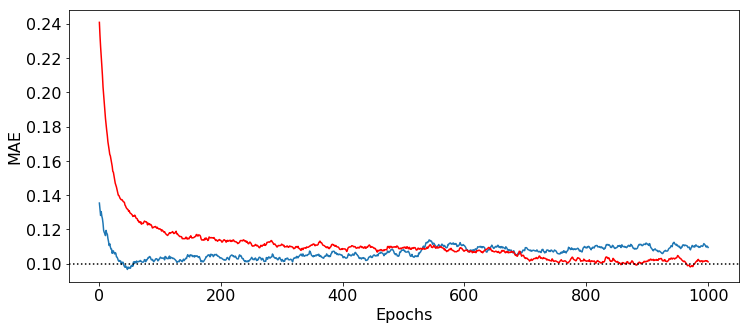

In [24]:
ax_maeh = plot_mae_history(results_model_cnn['train_mae_histories'], results_model_cnn['val_mae_histories'],
                          smoothed=True)
ax_maeh.axhline(y=0.10, ls=':', color='k');

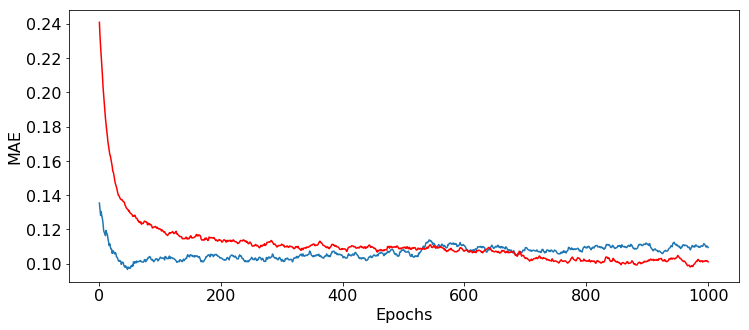

In [20]:
ax_maeh = plot_mae_history(results_model_cnn['train_mae_histories'], results_model_cnn['val_mae_histories'],
                          smoothed=True)

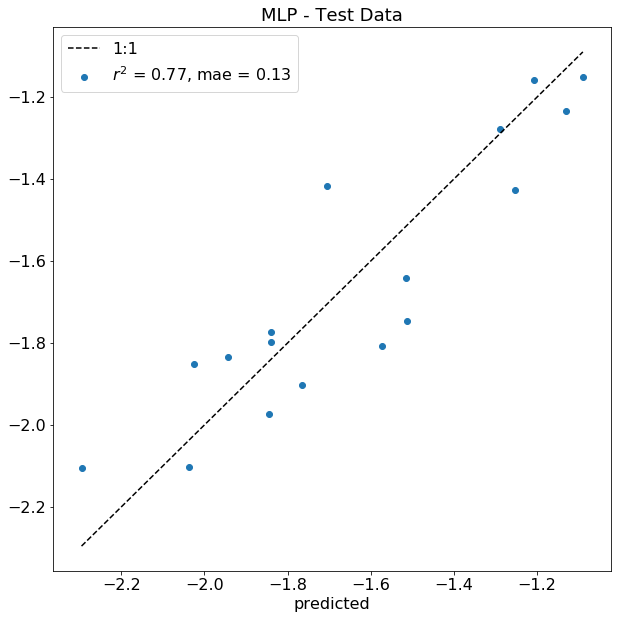

In [21]:
ax_fit_1 = plot_fits(model_cnn, X_test_, y_test_)

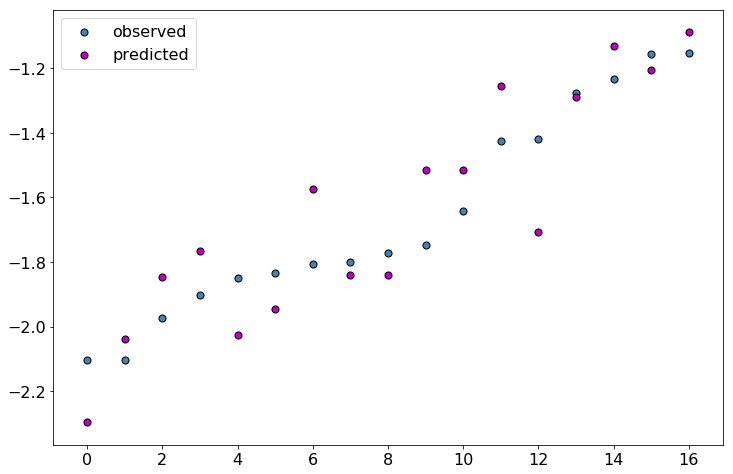

In [22]:
ax_fit_2 = plot_fits_2(model_cnn, X_test_, y_test_)